## Project 2

In this project we focus on the implementation of numerical algorithms for matrix approximation and time-dependent matrix analysis. More spesficially, we are to inspect multiple ways of finding the low-rank appoximation of some matrix $A(t) \in \mathbb{R}^{n x m}$, this for all values of t. Doing so we will look closer at some specific examples, looking at the accuracy of the low-rank approximation of our given matrix as well as the stability of the method. As we will see, there are some matrices that causes trouble for the accuracy of our low-rank approximation.

In [1]:
# import necessary files 
import lanczos_bidiag as lanczos
from Helper_functions import *
import numpy as np
import matplotlib.pyplot as plt
import cay_operator as cay

We start by implementing the Lanczos bidiagonalization algorithm, allowing for both with and without re-orthogonalization of our column-vectors. To test this implementation, we consider three randomly generated square matrices $A_1$, $A_2$ and $A_3$, all of different sizes: 

In [2]:
## Generate test-matrices

A1 = np.random.rand(4,4)
A2 = 5 * np.random.rand(20,20)
A3 = -3 * np.random.rand(100,100)

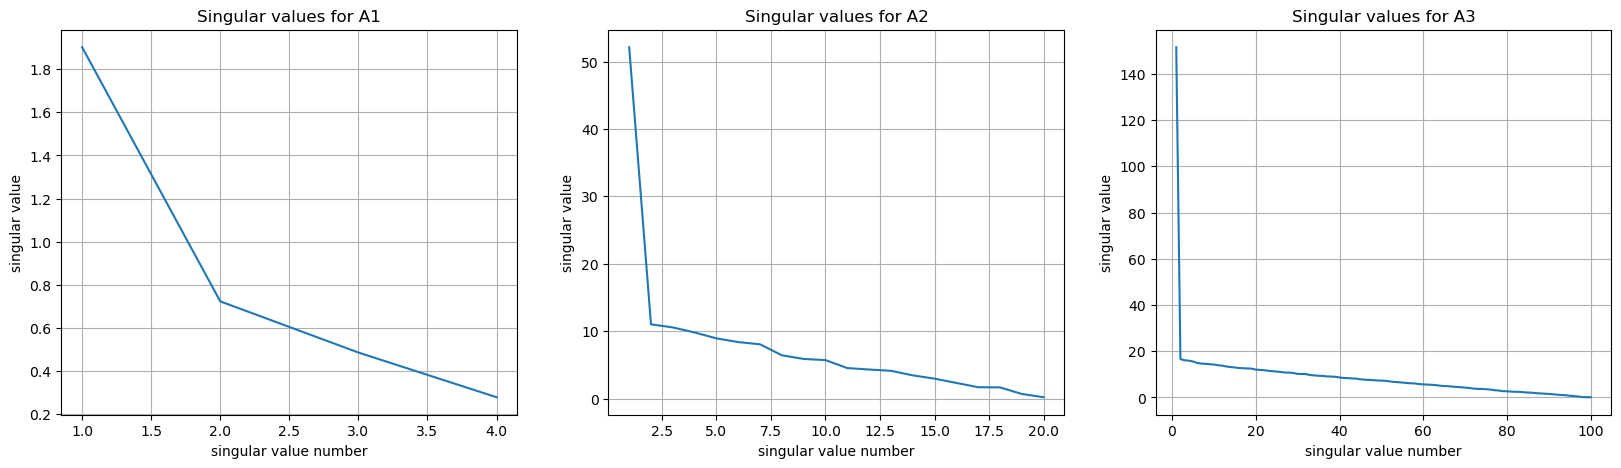

In [3]:
lanczos.plotSingularValues(A1,A2,A3)

Here we have three plots of singular values for different matrices. All three have in common that there exists a singular value greater than all the others by a big margin. We can exploit this when choosing k.

Having done so, we now wish to test out our implementation of finding a k-rank approximation through Lanczos bidiagonalization algortithm, and compare it to a SVD decomposition of our matrix. We here use $A_3$ as defined above as the matrix which is to be approximated. Having calculated the approximation, we then take Frobenius norm of the difference between $A_3$ and our approximations, and plot these for each value of $k$. 

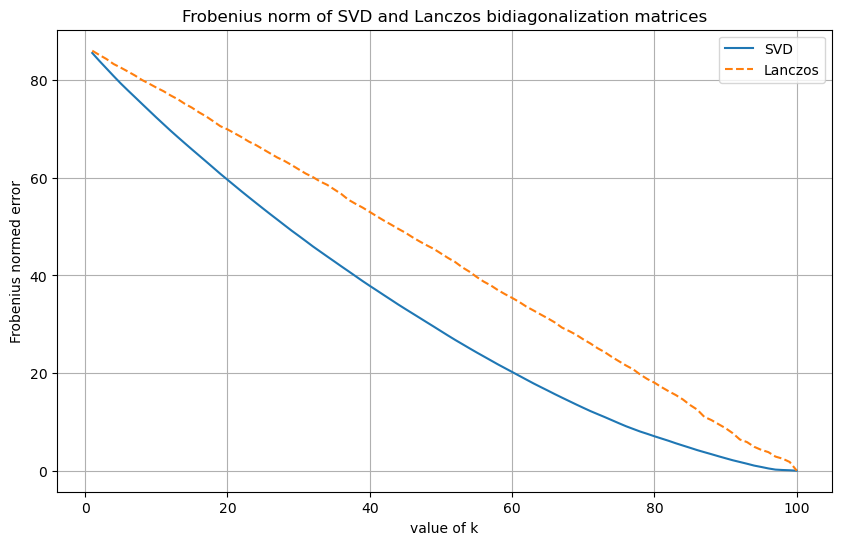

In [4]:
b = np.ones(100)
lanczos.compareApproximations(A3,b)

As we can see, the singular value decomposition is generally better than the Lanczos decomposition at approximating our matrix (measured in the Frobenius norm). Still, the Lanczos method approximates equally as good as SVD for a full rank decomposition; both giving a Frobenius norm of approximately zero.

Lastly, we compare the rounding errors  of  our implementation of lanczos bidiagonalization with and without re-orthogonalization, to see if re-orthogonalizing really is necessary. The error is measured as  the sum of the 2-norm of the dot-product of the column-vectors in P and Q respectively. We use the previously defined matrix $A_3$ and the right hand side $b$ as before.

In [5]:
lanczos.orthogonalityError(A3,b)

Without re-orthogonalization: 
Mean error for P:  1.075e-01   Mean error for Q:  1.077e-01
With re-orthogonalization: 
Mean error for P:  1.705e-12  Mean error for Q:  1.130e-13


Clearly, the re-orthogonalization greatly reduces the propagation of rounding errors in our algorithm.

# Rank k approximation to heat equation

The heat equation can be written on the following form.

\begin{equation}\tag{}

u_t = Au + uA \  \textrm{where } A = 

\begin{bmatrix}
-2 & 1 & \dots  & 0\\
1 & -2 & \dots & \vdots \\
\vdots & \vdots & \ddots \\
0 & 0 & \dots & -2
\end{bmatrix}

\end{equation}

we wish to solve a rank k approximation to this differation equation.

We start off by solving the system for an arbitrary k, we choose to use k = 10 as it is not so small as to lose too much information, while still being able to reap the benefits of lower ranks.

## Efficient implementation of Cayley transformation.

The iterative method employed for SVD at each time step impolys a Cayley transformation. This transformation is important in preserving the orthonormality of the columns in both matrices U and V. The Cayley operator is defined as follows:

$cay(B) = \left( I-\frac{1}{2}B\right)^{-1}\left( I+\frac{1}{2}B\right)$

The naive implementaion of this operator would for a matrix $B \in R^{nxn}$ scale as $O(n³)$

In our case, B can be expressed as $CD^T$, where $ C\in R^{nxp} \ D\in R^{nxp}$. By applying this and another technique, we can derive an improved method in the following form:

$ cay(CD^{T}) = I + C(I-\frac{1}{2}D^{T}C)^{-1}D^{T} $

This enhanced method exhibits a computational complexity of $O(p³)$, and we have the flexibility to select $p < n$ , resulting in a substantial increase in performance. This method will be referred to as factorized Cay.

In [6]:
n = 500
k = 10
np.random.seed(1)
dummi1 = np.random.rand(n,k)
dummi2 = np.random.rand(n,k)
Obj = [dummi1,dummi2]

In [20]:
%%timeit -n 5 -r 5
cay.cay_operator(Obj)

251 ms ± 97.9 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [23]:
%%timeit -n 40 -r 30
cay.cay_factorized(Obj)

4.42 ms ± 1.67 ms per loop (mean ± std. dev. of 30 runs, 40 loops each)


In [24]:
%%timeit -n 40 -r 30
cay.cay_factorized_optim(Obj)

3.8 ms ± 183 µs per loop (mean ± std. dev. of 30 runs, 40 loops each)


As we can see the normal implementasion of cay is very slow, and since it is preformed each timestep it crusel to have an effiecnt way of computing this. 

The second method is the factorized Cay and it alot faster, almost 50 times faster. 

We have also made an optimized version of the factorized cay method, that does not need to compute the whole  but only one of the blocks in the matrix and then use a linear combination of the inverse of this block on the remaining blocks.

We have also developed an optimized version of the factorized Cay method that avoids the computation of the entire matrix.


\begin{equation}\tag{}

(I-\frac{1}{2}D^TC)^{-1} = 

\begin{bmatrix}
I & 0.5I  \\
-0.5F^TF & I
\end{bmatrix}

\end{equation}

 Instead, it calculates only the inverse of one block within the matrix and employs a linear combination of this invsese block for the remaining blocks.

# Solving the Heat equation

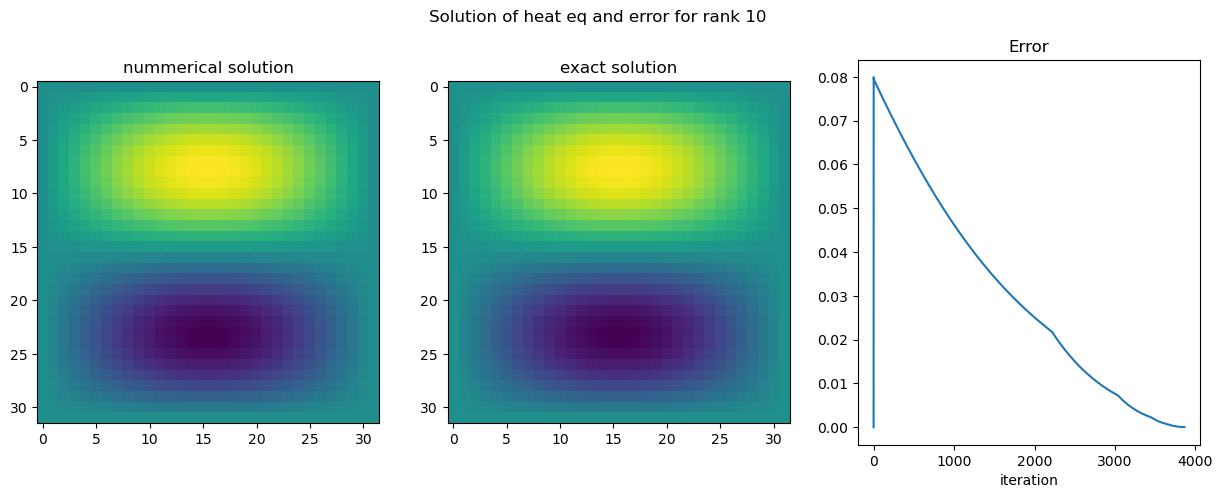

In [10]:
tol = 1.e-5
tf = 0.2
h0 = 0.1 
k = 10 

Yt,_,_,u_ex_t,error,t_vals = solve_heat_eq(k,h0,tf,tol)
plot_heat_sol_and_error(k,Yt,u_ex_t,error)

The numerical solution and the exact solution appear to be indistinguishable, and the error is decreasing for each iteration.

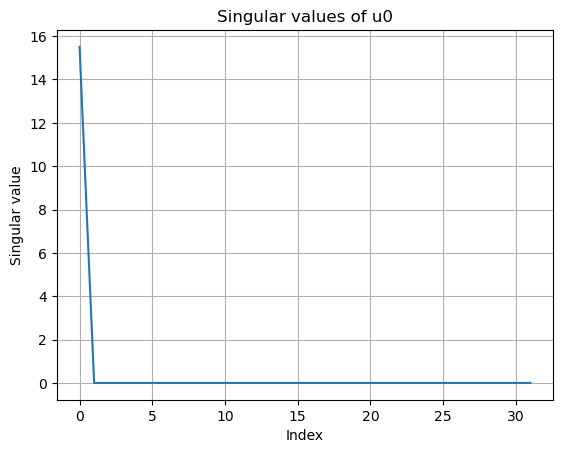

In [11]:
t0 = 0
N = 32

# Initialize u and u_dot
m,n = N,N
u0 = tilr.u_fun(g,m,n) 
S_0 = np.linalg.svd(u0)[1]
plt.plot(S_0)
plt.title('Singular values of u0')
plt.xlabel('Index')
plt.ylabel('Singular value')
plt.grid()
plt.show()

Here we have a plot of the singular values, and it seems we only have one significant singular value. We can exploit this and choose k to be one. This is favorable as it is less computationally intensive. We will check if we are still able to extract the same solution. 

### Solving with K = 1

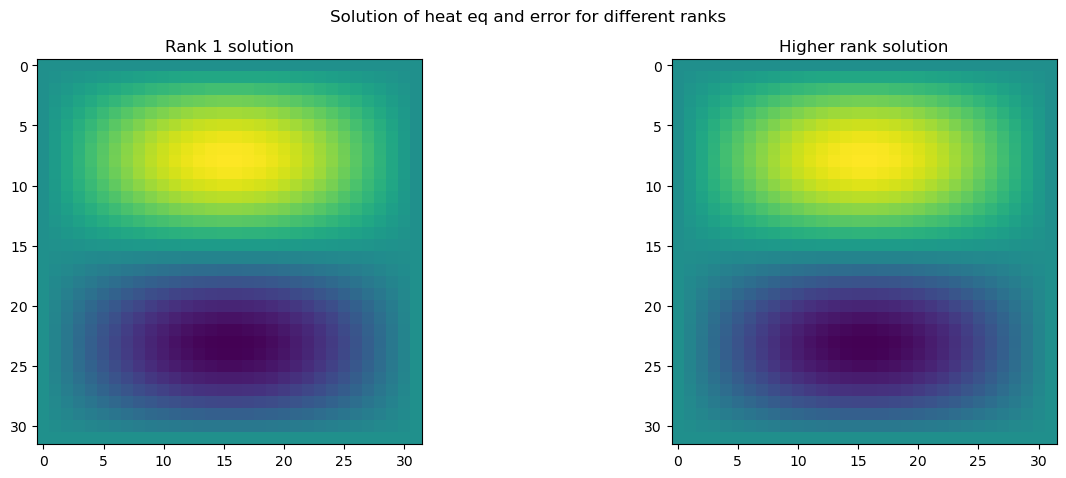

In [12]:
tol = 1.e-5
tf = 0.2
h0 = 0.1 # initial step size in vssi
k = 1 # k-rank approx

Ytk1,Ut,Vt,u_ex_tk1,error,t_vals = solve_heat_eq(k,h0,tf,tol)
plot_heat_diff_ranks(Ytk1,Yt)

There is no visible difference in the two plots. This indicates that as long as the significant singular values are included, one can expect good results. This is an especially interesting result as one can save a lot of computational effort as long as the rank of the matrix is smaller than the size.

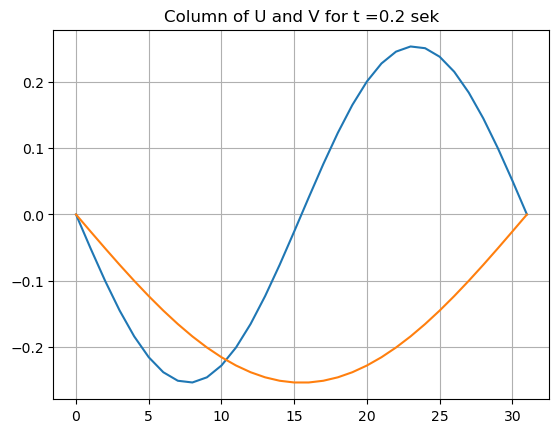

In [13]:
plt.title(f'Column of U and V for t ={tf} sek')
plt.plot(Ut[-1,:,0],label='U')
plt.plot(Vt[-1,:,0],label='V')
plt.plot()
plt.grid()
plt.show()

These results are intesting as they look like the two diffrent factors of g, with $g = sin(\pi x)sin(2 \pi x)$

# Error analysis

Moving on to a more interesting/complicated example,
we wish to solve the differation equation 

$$\frac{dA(t)}{dt} = ( \ Q_1(t)(A_1 + e^{t} A_2)Q^T_2(t) \ )' \ \textrm{with} \ Q'_i = T_i Q_i \quad \text{for } i = 1,2 $$
while 

$$
T_1 := \begin{bmatrix}
0 & -1 & \cdots & 1 \\
1 & 0 & \cdots & -1 \\
\vdots & \vdots & \ddots & \vdots \\
-1 & 1 & \cdots & 0 \\
\end{bmatrix}

\ \textrm{and} \ \

T_2 := \begin{bmatrix}
0 & -\frac{1}{2} & -1 & \cdots & 0 \\
\frac{1}{2} & 0 & \ddots & \ddots &\vdots \\
1 & \ddots & \ddots & \ddots & -1 \\
\vdots & \ddots & \ddots & \ddots & -\frac{1}{2} \\
0 & \dots & 1 & \frac{1}{2} & 0 \\
\end{bmatrix}.

$$



In [14]:
tol = 1.e-2
t0 = 0
tf = 1
h0 = 0.9 # initial step size in vssi

Yt,Xt,Yt_dot,Wt,t_vals1 = solve_task4(10,ex.A,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals1,Xt,Yt,ex.A,Yt_dot,ex.A_dot,Wt)
norm_array1 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

Yt,Xt,Yt_dot,Wt,t_vals2 = solve_task4(20,ex.A,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals2,Xt,Yt,ex.A,Yt_dot,ex.A_dot,Wt)
norm_array2 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

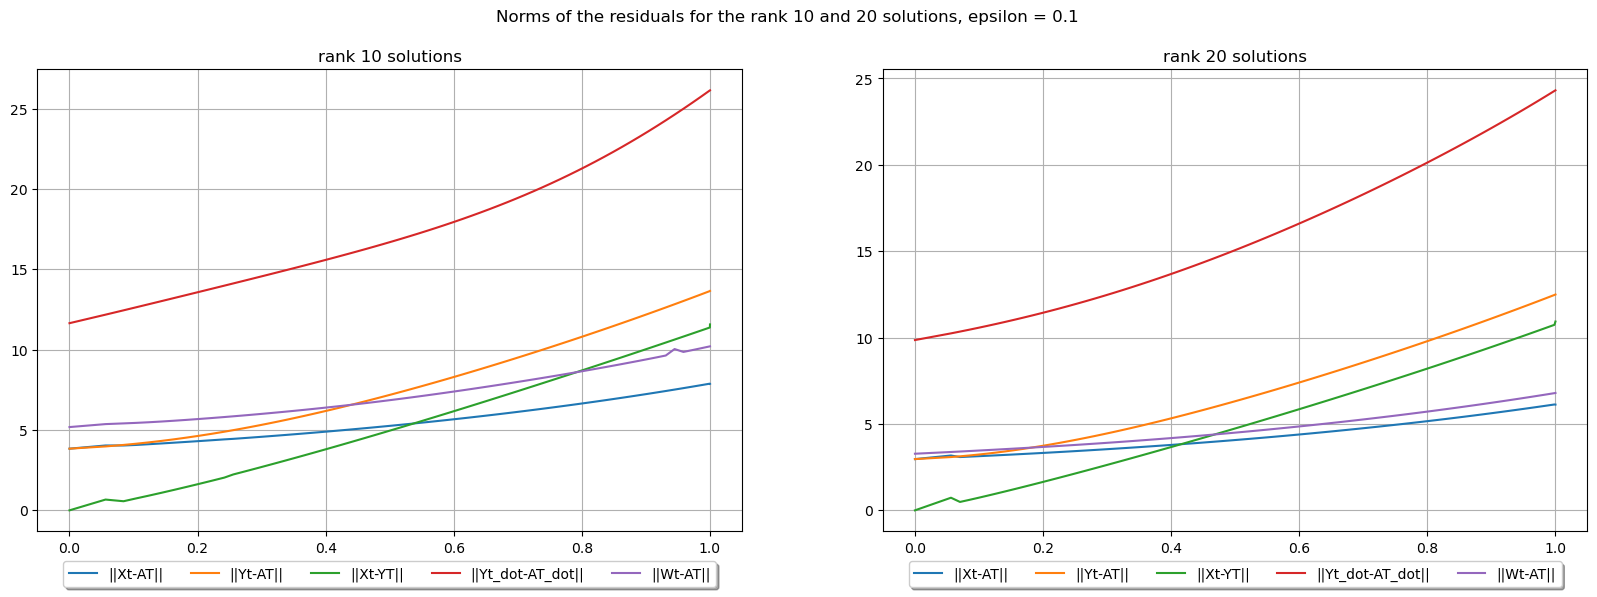

In [15]:
plot_norms(t_vals1,t_vals2,norm_array1,norm_array2,10**-1)

Looking at the plot of the error, we observe that $X(t)$ is closest to $A(t)$. This was expected, as it represents the best rank-k approximation to our equation. The Lanczos bidiagonalization method is not far behind. Interestingly, the dynamic low-rank approximation starts off as the best but falls behind after enough time steps. This can be explained by the fact that we start with computing the SVD of $A(0)$ and utilize this as our initial conditions. The main difference between rank 10 and rank 20 is that we start off with a lower error, which is expected as we have more of the information.

In [16]:
tol = 1.e-2
t0 = 0
tf = 1
h0 = 0.5 # initial step size in vssi

Yt,Xt,Yt_dot,Wt,t_vals1 = solve_task4(10,ex.A_3,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals1,Xt,Yt,ex.A_3,Yt_dot,ex.A_3_dot,Wt)
norm_array1 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

Yt,Xt,Yt_dot,Wt,t_vals2 = solve_task4_3(20,ex.A_3,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals2,Xt,Yt,ex.A_3,Yt_dot,ex.A_3_dot,Wt)
norm_array2 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

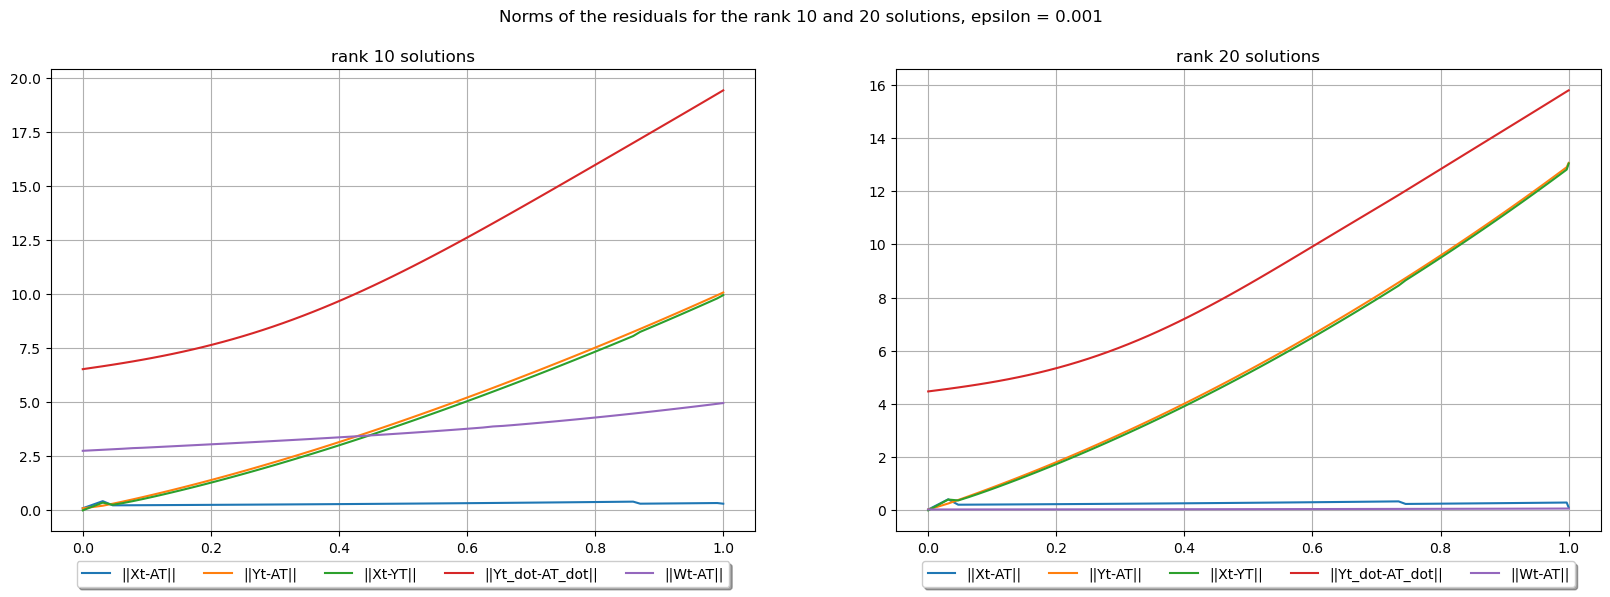

In [17]:
plot_norms(t_vals1,t_vals2,norm_array1,norm_array2,10**-3)

We see a lot of the same behavior. Once again, the higher-rank approximation starts off with a lower error. In addition, since epsilon is a lot less, the increase in error is increasing slower.

# Singular value analysis

Lets now consider a slightly different matrix, exchanging the time-dependency of $e^t$ to $cos(t)$ in the last example. More explicitly, we wish to solve the differential equation
$$
\frac{dA(t)}{dt} = ( \ Q_1(t)(A_1 + \cos(t) A_2)Q^T_2(t) \ )' \ \textrm{with} \ Q'_i = T_i Q_i \quad \text{for } i = 1,2 
$$

We inspect the singular values of this matrix for rank $5$, and compare them to the singular values of dynamic low-rank approximation for the same rank.

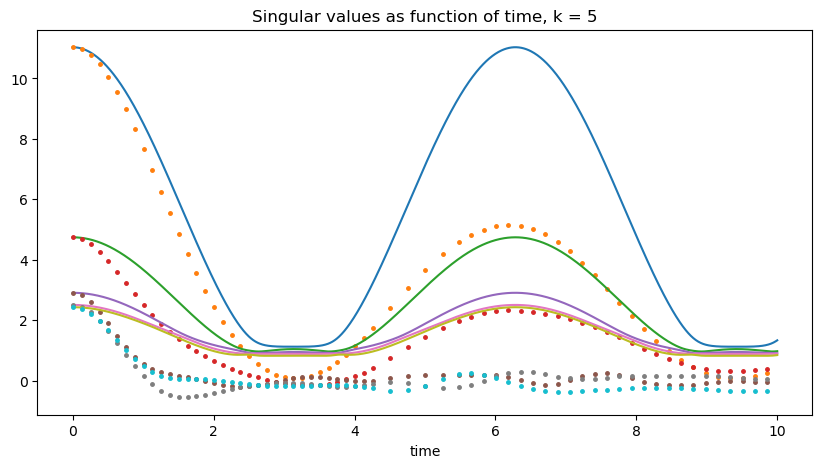

In [18]:
plot_singular_values(5)

Here, the dotted lines are the approximated singular values, while the solid line are the singular values of the exact solution. We here only plot the approximated singular values for every 10'th time step.

What was to expected here was that the approximated singular values "followed" the exact ones almost everywhere. There's seem to be a problem causing some damping of our approximated singular values, but we will for discussion's sake act as if we got the result that one should get.

As we can see, the largest singular value of our rank k approximation does not seem to be the largest for all time steps. Since our rank k approximation only chooses the k largest singular values at time $t_0$, it loses some information about the remaining singular values. In this example, this means that at one of the smaller singular values at the start, ends up being the largest one around time $t \approx 3$. In other words, we get a discontinouity due to the overlap of singular values, with one residing within the approximation and the other positioned outside. 

To track this larger singular value (when $t \approx 3$), we increase $k$ to 20 and try again.

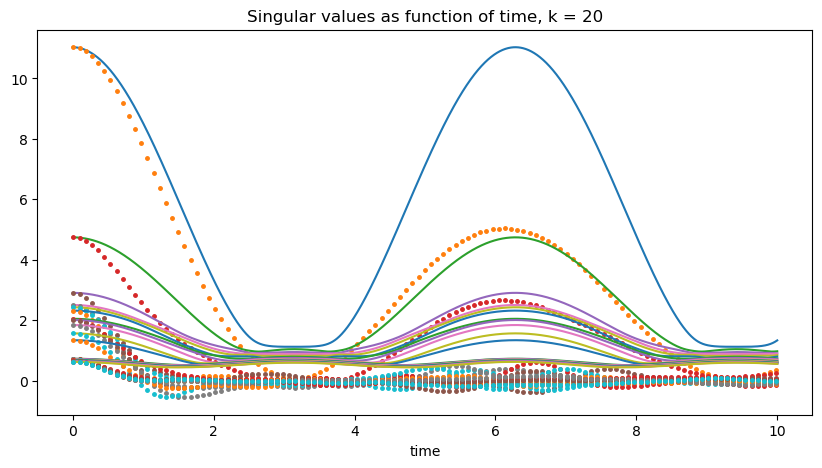

In [19]:
plot_singular_values(20)

## kommenter